## Recursive Least Squares

In [1]:
import control.matlab as cnt
import numpy as np
from utils import (
    W_V,
    plot_bode,
    plot_response,
    plot_responses,
)

from sippy_unipi import system_identification
from sippy_unipi.datasets import gen_gbn_seq, load_sample_siso, white_noise_var
from sippy_unipi.evaluate import validation
from sippy_unipi.typing import IOMethods

np.random.seed(0)

In [2]:
modes = ["FIXED", "IC"]
ylegends = ["System", "ARMAX", "ARX", "OE"]

n_samples = 401
ts = 1.0
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_siso(
    n_samples, ts, seed=0
)

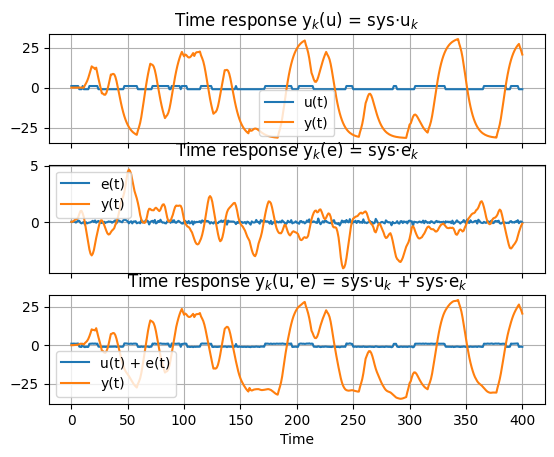

In [3]:
fig = plot_responses(
    time,
    [Usim, Uerr, Utot],
    [Ysim, Yerr, Ytot],
    ["u", "e", ["u", "e"]],
)

/app/sippy_unipi/identification.py:99: UserWarning: Ignoring argument 'IC' as fixed orders are provided.
  warn("Ignoring argument 'IC' as fixed orders are provided.")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


RMSE = 42.92
R2 = -4663.95
RMSE = 46.19
R2 = -5401.02
RMSE = 642.97
R2 = -1046849.24


/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: Fu

/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: Fu

/opt/pysetup/.venv/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/s

RMSE = 16.43
R2 = -822.18
RMSE = 16.43
R2 = -822.16
RMSE = 15.93
R2 = -773.10


/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: Fu

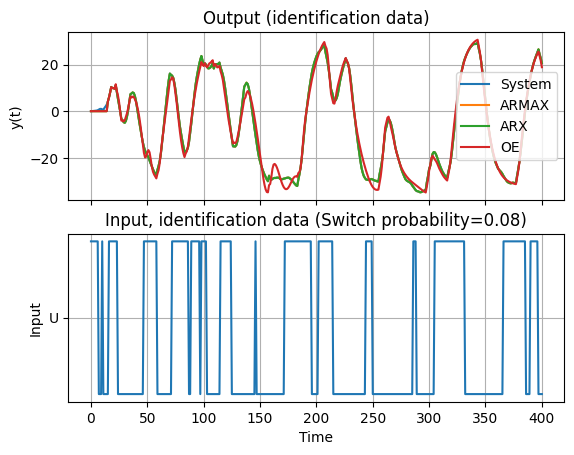

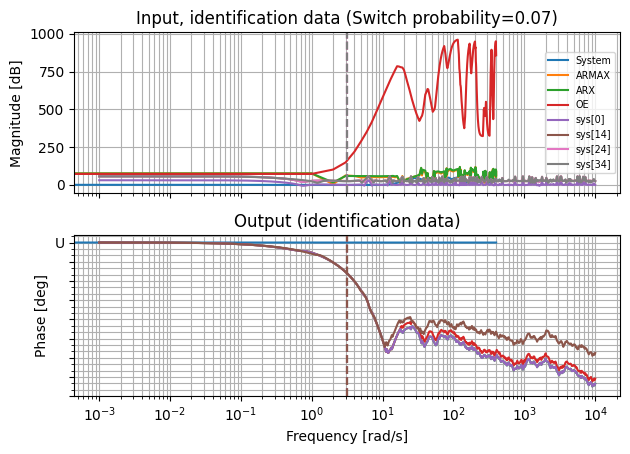

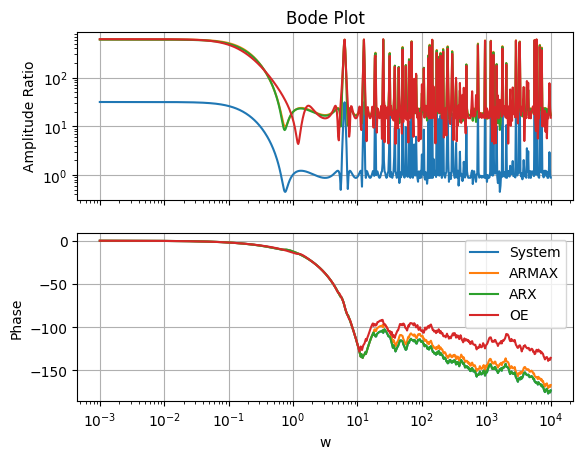

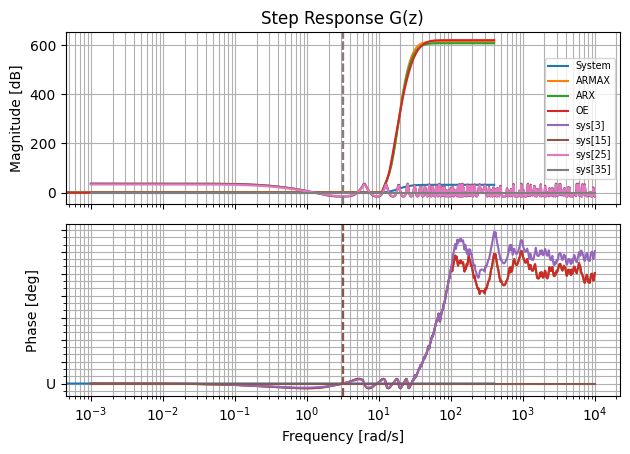

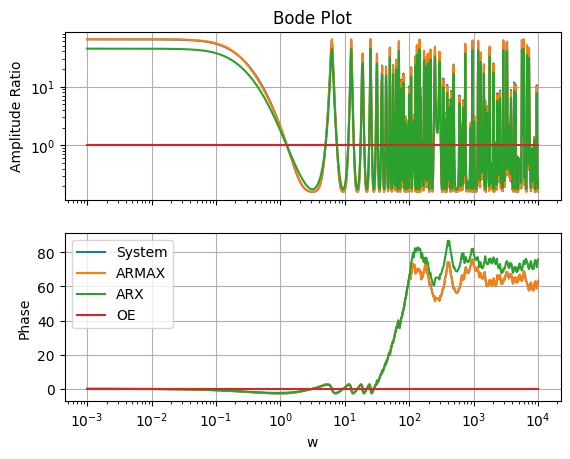

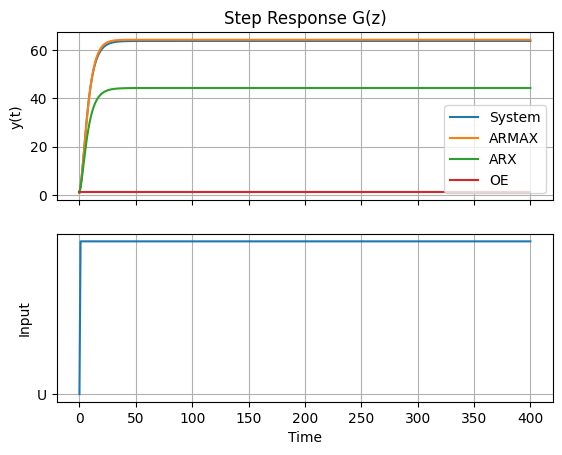

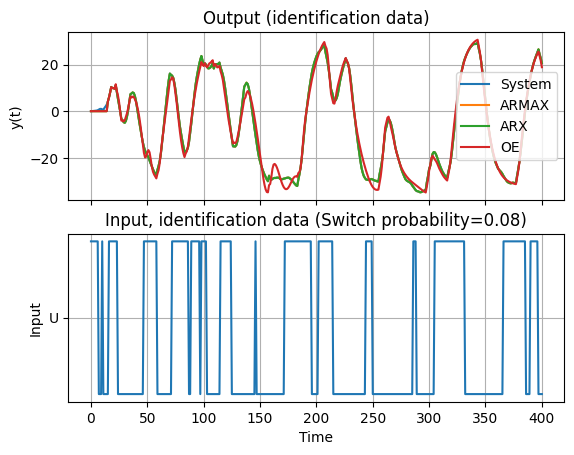

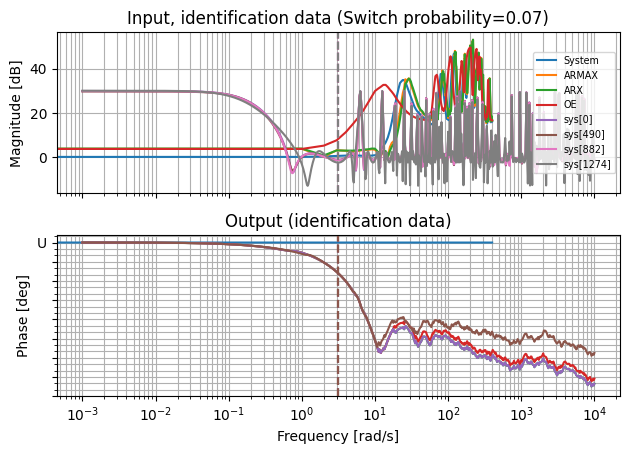

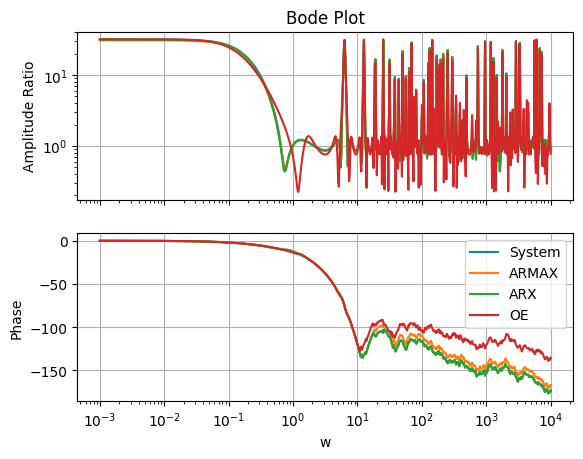

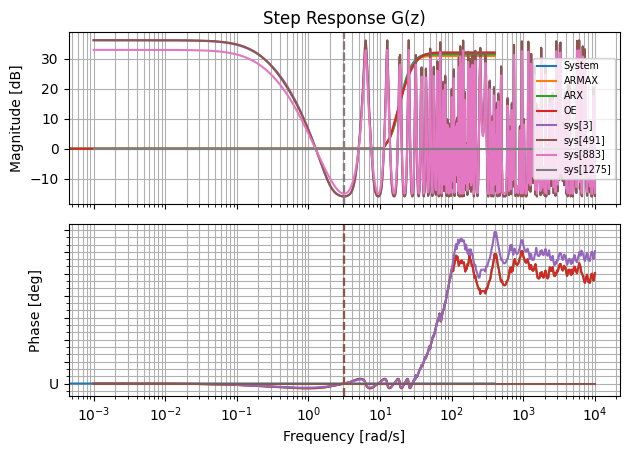

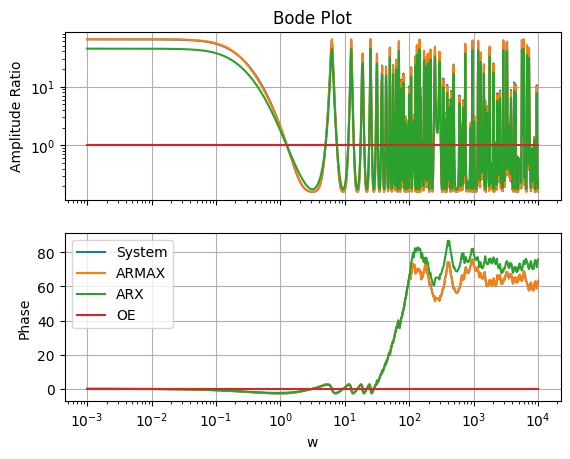

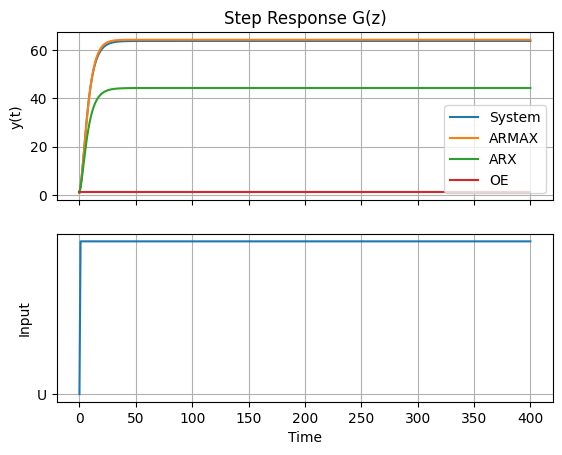

In [4]:
for mode in modes:
    if mode == "IC":
        na_ord = (4, 4)
        nb_ord = (3, 3)
        nc_ord = (2, 2)
        nd_ord = (3, 3)
        nf_ord = (4, 4)
        theta = (11, 11)

    elif mode == "FIXED":
        na_ord = [4]
        nb_ord = [[3]]
        nc_ord = [2]
        nf_ord = [4]
        theta = [[11]]

    identification_params: dict[
        IOMethods,
        tuple[tuple[list[int] | list[list[int]] | tuple[int, int], ...], dict],
    ] = {
        "ARMAX": (
            (na_ord, nb_ord, nc_ord, theta),
            {"IC": "BIC", "id_mode": "RLLS"},
        ),
        "ARX": ((na_ord, nb_ord, theta), {"IC": "BIC", "id_mode": "RLLS"}),
        "OE": ((nb_ord, nf_ord, theta), {"IC": "BIC", "id_mode": "RLLS"}),
    }

    syss = []
    for method, orders_params in identification_params.items():
        orders, params = orders_params
        sys_id = system_identification(
            Ytot, Usim, method, *orders, max_iter=300, **params
        )
        syss.append(sys_id)

    ys = [Ytot] + [getattr(sys, "y_id").T for sys in syss]

    fig = plot_response(
        time,
        ys,
        Usim,
        legends=[ylegends, ["U"]],
        titles=[
            "Output (identification data)",
            "Input, identification data (Switch probability=0.08)",
        ],
    )

    switch_probability = 0.07
    input_range = (0.5, 1.5)
    [U_valid, _, _] = gen_gbn_seq(
        n_samples, switch_probability, scale=input_range
    )
    white_noise_variance = [0.01]
    e_valid = white_noise_var(U_valid.size, white_noise_variance)[0]

    Yvalid1, time, Xsim = cnt.lsim(g_sys, U_valid, time)
    Yvalid2, time, Xsim = cnt.lsim(h_sys, e_valid, time)
    Ytotvalid = Yvalid1 + Yvalid2

    ys = [Ytotvalid] + [
        validation(sys, U_valid, Ytotvalid, time) for sys in syss
    ]

    fig = plot_response(
        time,
        ys,
        Usim,
        legends=[ylegends, ["U"]],
        titles=[
            "Input, identification data (Switch probability=0.07)",
            "Output (identification data)",
        ],
    )

    for y, sys in zip(ys[1:], syss):
        yv = y.T
        rmse = np.sqrt(np.mean((Ytotvalid - yv) ** 2))
        R2 = 1 - np.sum((Ytotvalid - yv) ** 2) / np.sum(
            (Ytotvalid - np.mean(Ytotvalid)) ** 2
        )
        print(f"RMSE = {rmse:.2f}")
        print(f"R2 = {R2:.02f}")
    
    u = np.ones_like(time)
    u[0] = 0

    for tf in ["G", "H"]:
        syss_tfs = [
            locals()[f"{tf.lower()}_sys"],
            *[getattr(sys, tf) for sys in syss],
        ]
        mags, fis, oms = zip(*[cnt.bode(sys, W_V) for sys in syss_tfs])

        fig = plot_bode(
            oms[0],
            mags,
            fis,
            ylegends,
        )

        ys, _ = zip(*[cnt.step(sys, time) for sys in syss_tfs])

        fig = plot_response(
            time,
            ys,
            u,
            legends=[ylegends, ["U"]],
            titles=["Step Response G(z)", None],
        )